In [ ]:
# Install the necessary dependencies

import os
import sys
!{sys.executable} -m pip install --quiet seaborn pandas scikit-learn numpy matplotlib jupyterlab_myst ipython

---
license:
    code: MIT
    content: CC-BY-4.0
github: https://github.com/ocademy-ai/machine-learning
venue: By Ocademy
open_access: true
bibliography:
  - https://raw.githubusercontent.com/ocademy-ai/machine-learning/main/open-machine-learning-jupyter-book/references.bib
---

# Random forest

[Leo Breiman](https://en.wikipedia.org/wiki/Leo_Breiman) managed to apply bootstrapping not only in statistics but also in machine learning. He, along with Adel Cutler, extended and improved the random forest algorithm [proposed by Tin Kam Ho](http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf). They combined the construction of uncorrelated trees using [CART](https://en.wikipedia.org/wiki/Predictive_analytics#Classification_and_regression_trees_.28CART.29), bagging, and the [random subspace method](https://en.wikipedia.org/wiki/Random_subspace_method).  

Decision trees are a good choice for the base classifier in bagging because they are quite sophisticated and can achieve zero classification error on any sample. The random subspace method reduces the correlation between the trees and thus prevents overfitting. With bagging, the base algorithms are trained on different random subsets of the original feature set.

The following algorithm constructs an ensemble of models using the random subspace method:

1. Let the number of instances be equal to $\large \ell$, and the number of features be equal to $\large d$.
2. Choose $\large L$ as the number of individual models in the ensemble. 
3. For each model $\large l$, choose the number of features $\large dl < d$. As a rule, the same value of $\large dl$ is used for all the models.
4. For each model $\large l$, create a training set by selecting $\large dl$ features at random from the whole set of $\large d$ features.
5. Train each model.
6. Apply the resulting ensemble model to a new instance by combining the results from all the models in $\large L$. You can use either majority voting or aggregation of the posterior probabilities.

In [2]:
from IPython.display import HTML
display(HTML("""
<p style="text-align: center;">
<iframe src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/html/random-forest/index.html" width="105%" height="700px;" style="border:none;" scrolling="yes"></iframe>
A demo of Decision Tree. <a href="https://mlu-explain.github.io/random-forest/">[source]</a>
</p>
"""))

In [3]:
from IPython.display import HTML
display(HTML("""
<p style="text-align: center;">
<iframe src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/html/random-forest-2/index.html" width="105%" height="1000px;" style="border:none;" scrolling="no"></iframe>
A demo of Decision Tree. <a href="https://cs.stanford.edu/~karpathy/svmjs/demo/demoforest.html">[source]</a>
</p>
"""))

In [4]:
from IPython.display import HTML
display(HTML("""
<p style="text-align: center;">
<iframe src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/html/random-forest-3/index.html" width="110%" height="600px;" style="border:none;" scrolling="no"></iframe>
A demo of Decision Tree. <a href="https://nlhlong01.github.io/playground/#dataset=circle&regDataset=reg-plane&noise=25&seed=0.59759&showTestData=false&discretize=false&percTrainData=60&problem=classification&percSamples=50&nTrees=100&maxDepth=5">[source]</a>
</p>
"""))

## Algorithm

The algorithm for constructing a random forest of $\large N$ trees goes as follows:

* For each $\large k = 1, \dots, N$:

    * Generate a bootstrap sample $\large X_k$.
    * Build a decision tree $\large b_k$ on the sample $\large X_k$:

        * Pick the best feature according to the given criteria. Split the sample by this feature to create a new tree level. Repeat this procedure until the sample is exhausted.
        * Building the tree until any of its leaves contains no more than $\large n_\text{min}$ instances or until a certain depth is reached.
        * For each split, we first randomly pick $\large m$ features from the $\large d$ original ones and then search for the next best split only among the subset.

The final classifier is defined by:
$$\large a(x) = \frac{1}{N}\sum_{k = 1}^N b_k(x)$$

We use the majority voting for classification and the mean for regression.

For classification problems, it is advisable to set $\large m = \sqrt{d}$. For regression problems, we usually take $\large m = \frac{d}{3}$, where $\large d$ is the number of features. It is recommended to build each tree until all of its leaves contain only $\large n_\text{min} = 1$ examples for classification and $\large n_\text{min} = 5$ examples for regression. 

You can see random forest as bagging of decision trees with the modification of selecting a random subset of features at each split.

## Comparison with Decision Trees and Bagging

In [5]:
# Disable warnings in Anaconda
import warnings

import numpy as np

warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
from sklearn.datasets import make_circles
from sklearn.ensemble import (BaggingClassifier, BaggingRegressor,
                              RandomForestClassifier, RandomForestRegressor)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [6]:
n_train = 150        
n_test = 1000       
noise = 0.1

# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

Text(0.5, 1.0, 'Decision tree, MSE = 20.50')

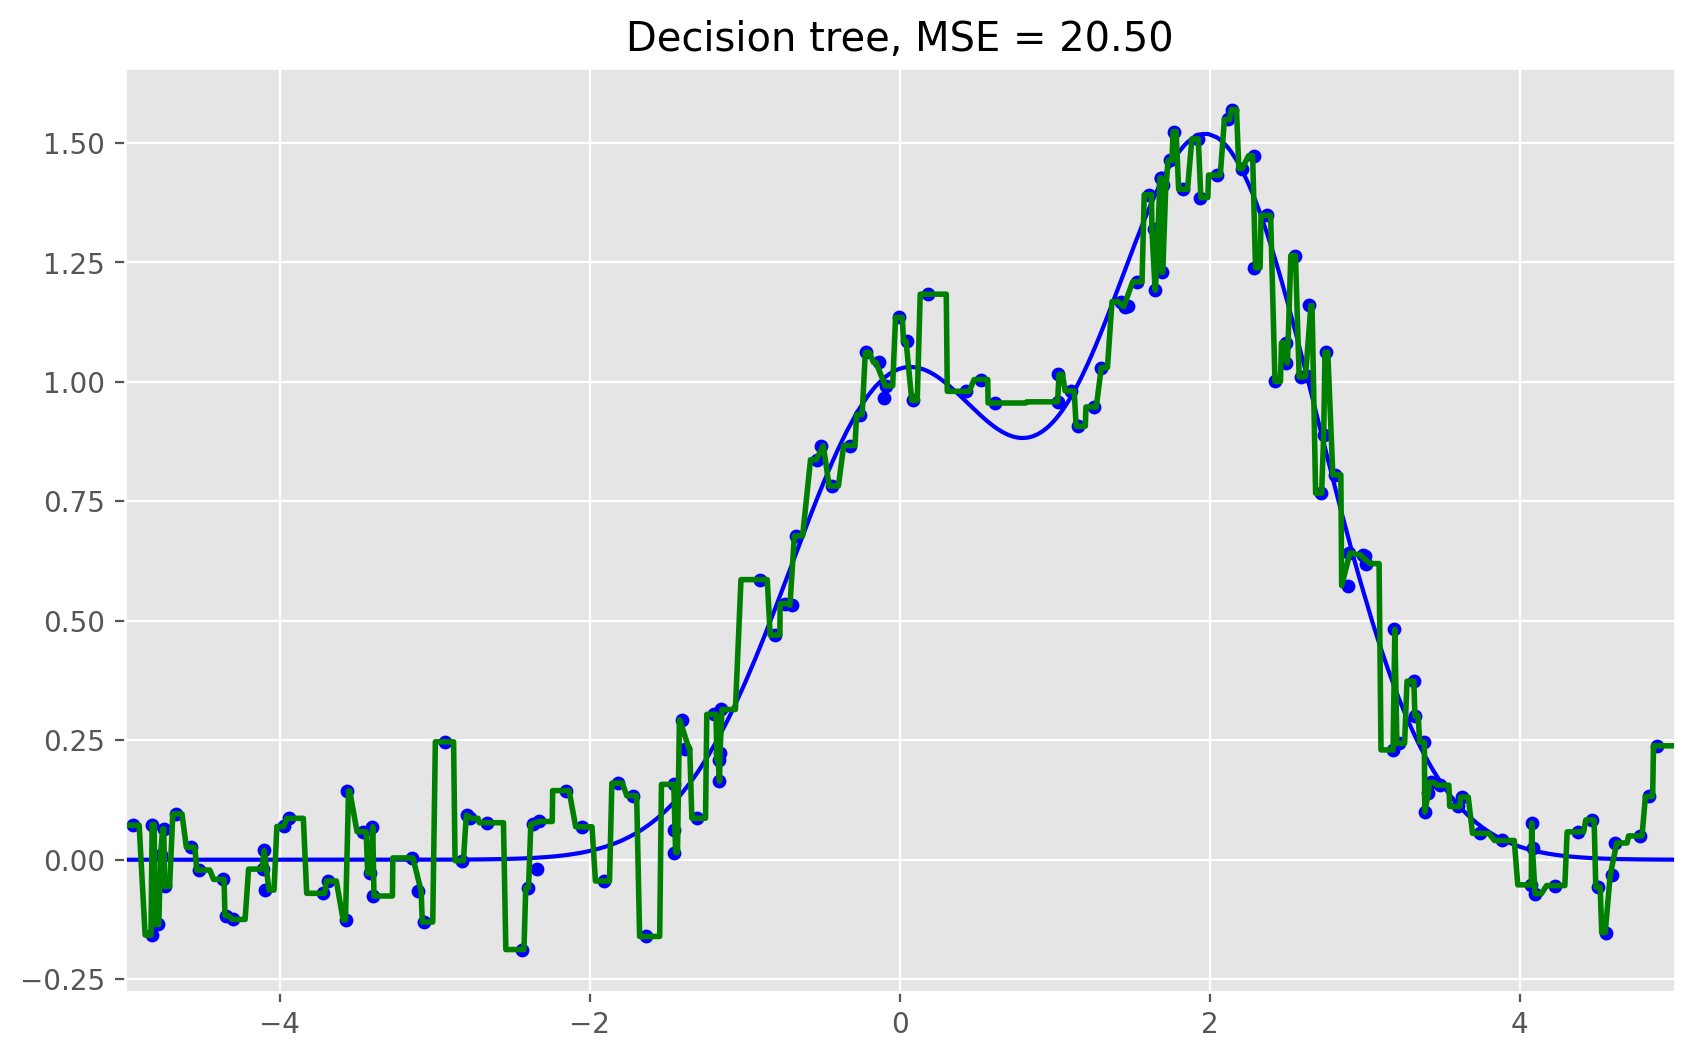

In [7]:
# One decision tree regressor
dtree = DecisionTreeRegressor().fit(X_train, y_train)
d_predict = dtree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, d_predict, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree, MSE = %.2f" % np.sum((y_test - d_predict) ** 2))

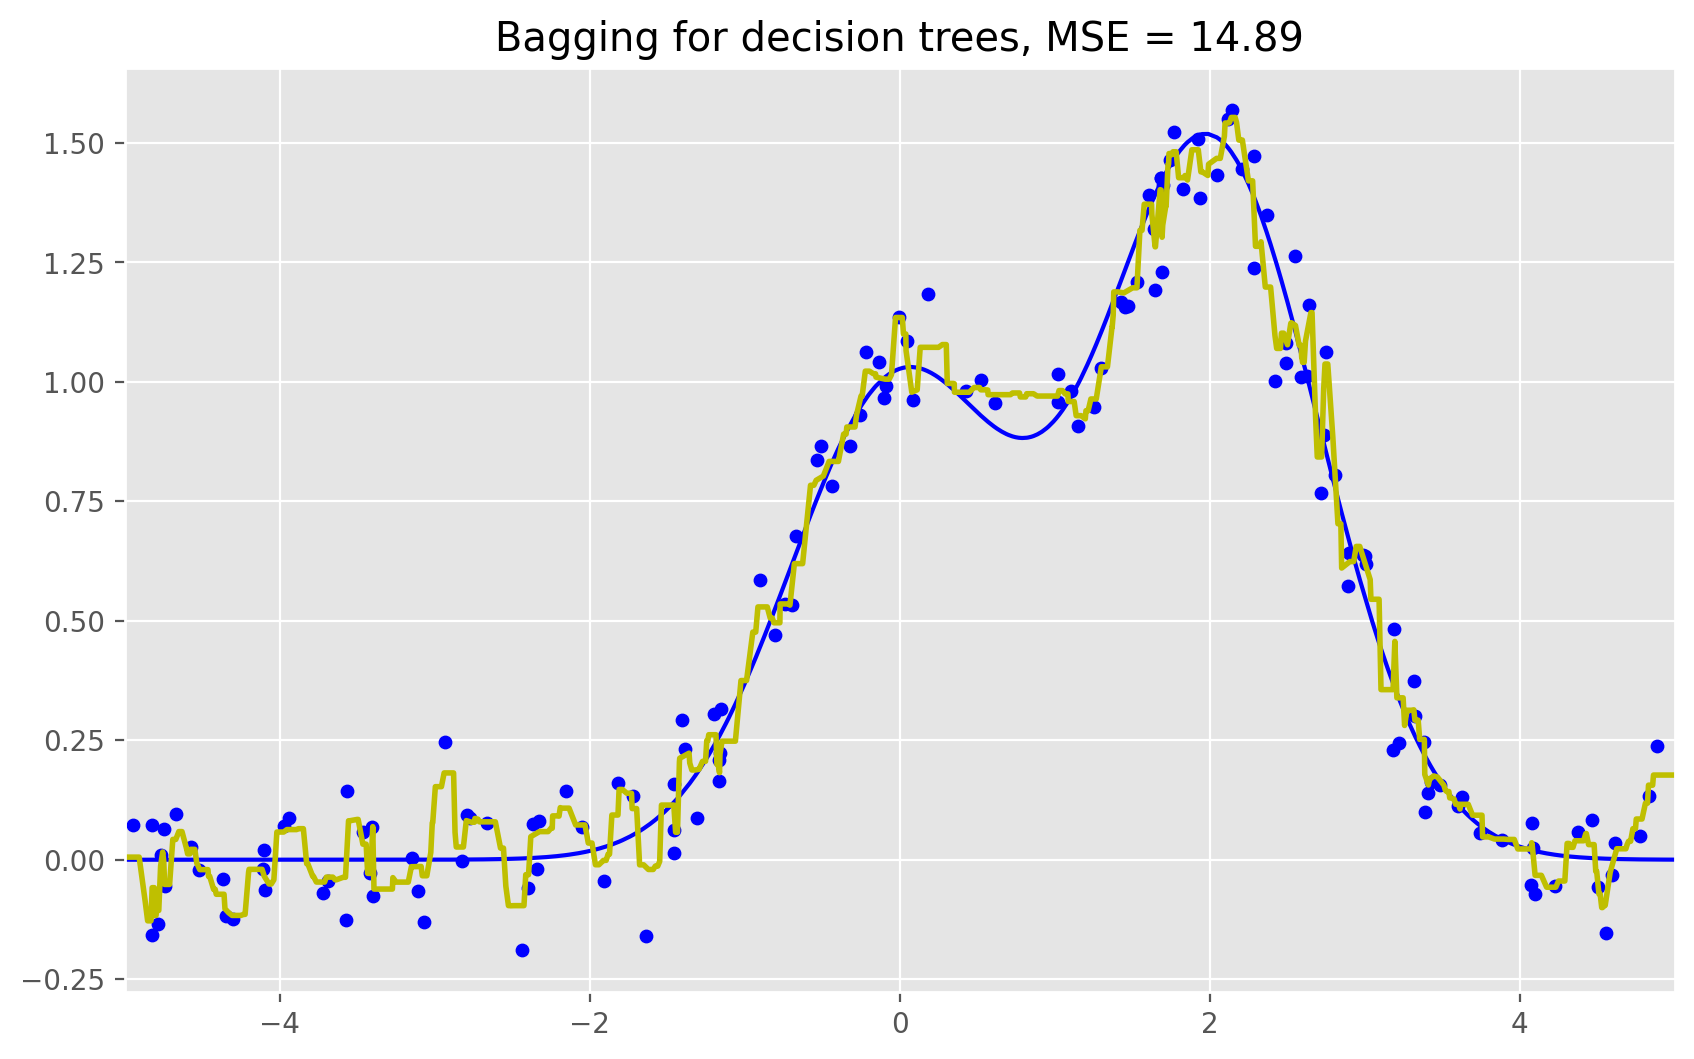

In [8]:
# Bagging with a decision tree regressor
bdt = BaggingRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
bdt_predict = bdt.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, bdt_predict, "y", lw=2)
plt.xlim([-5, 5])
plt.title("Bagging for decision trees, MSE = %.2f" % np.sum((y_test - bdt_predict) ** 2));

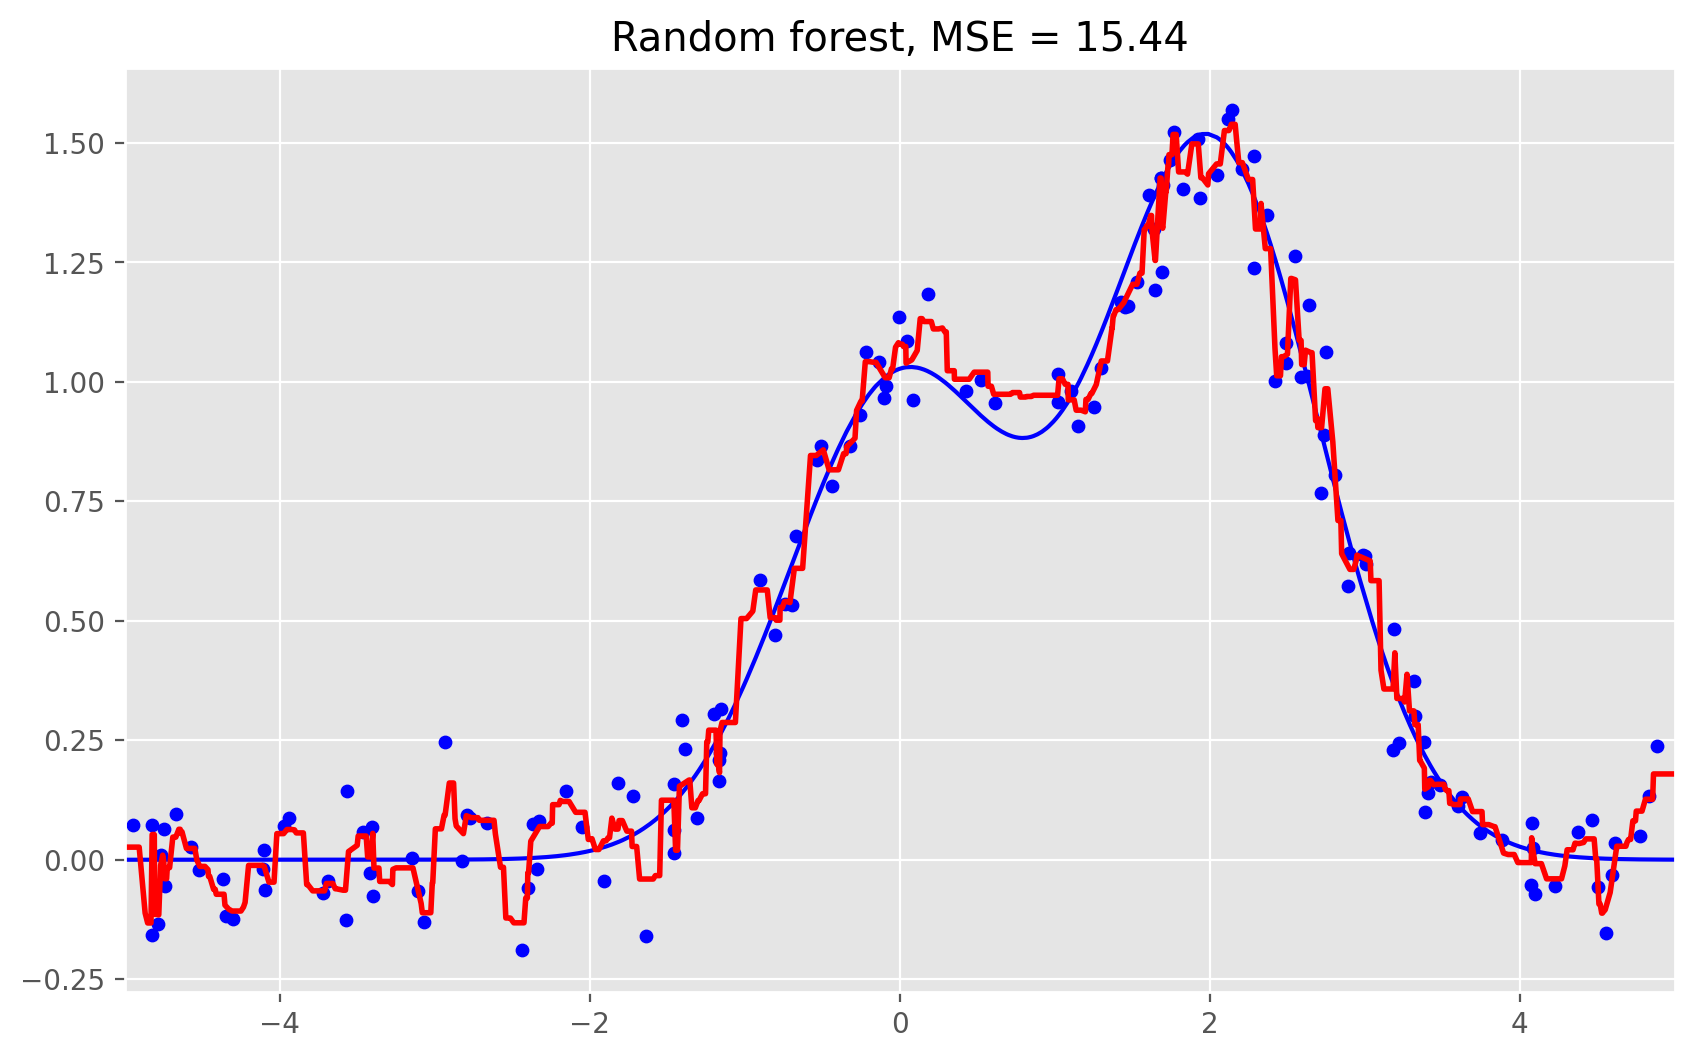

In [9]:
# Random Forest
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, rf_predict, "r", lw=2)
plt.xlim([-5, 5])
plt.title("Random forest, MSE = %.2f" % np.sum((y_test - rf_predict) ** 2));

As we can see from our graphs and the MSE values above, a random forest of 10 trees achieves a better result than a single decision tree and is comparable to bagging with 10 trees. The main difference between random forests and bagging is that, in a random forest, the best feature for a split is selected from a random subset of the available features while, in bagging, all features are considered for the next best split.

We can also look at the advantages of random forests and bagging in classification problems:

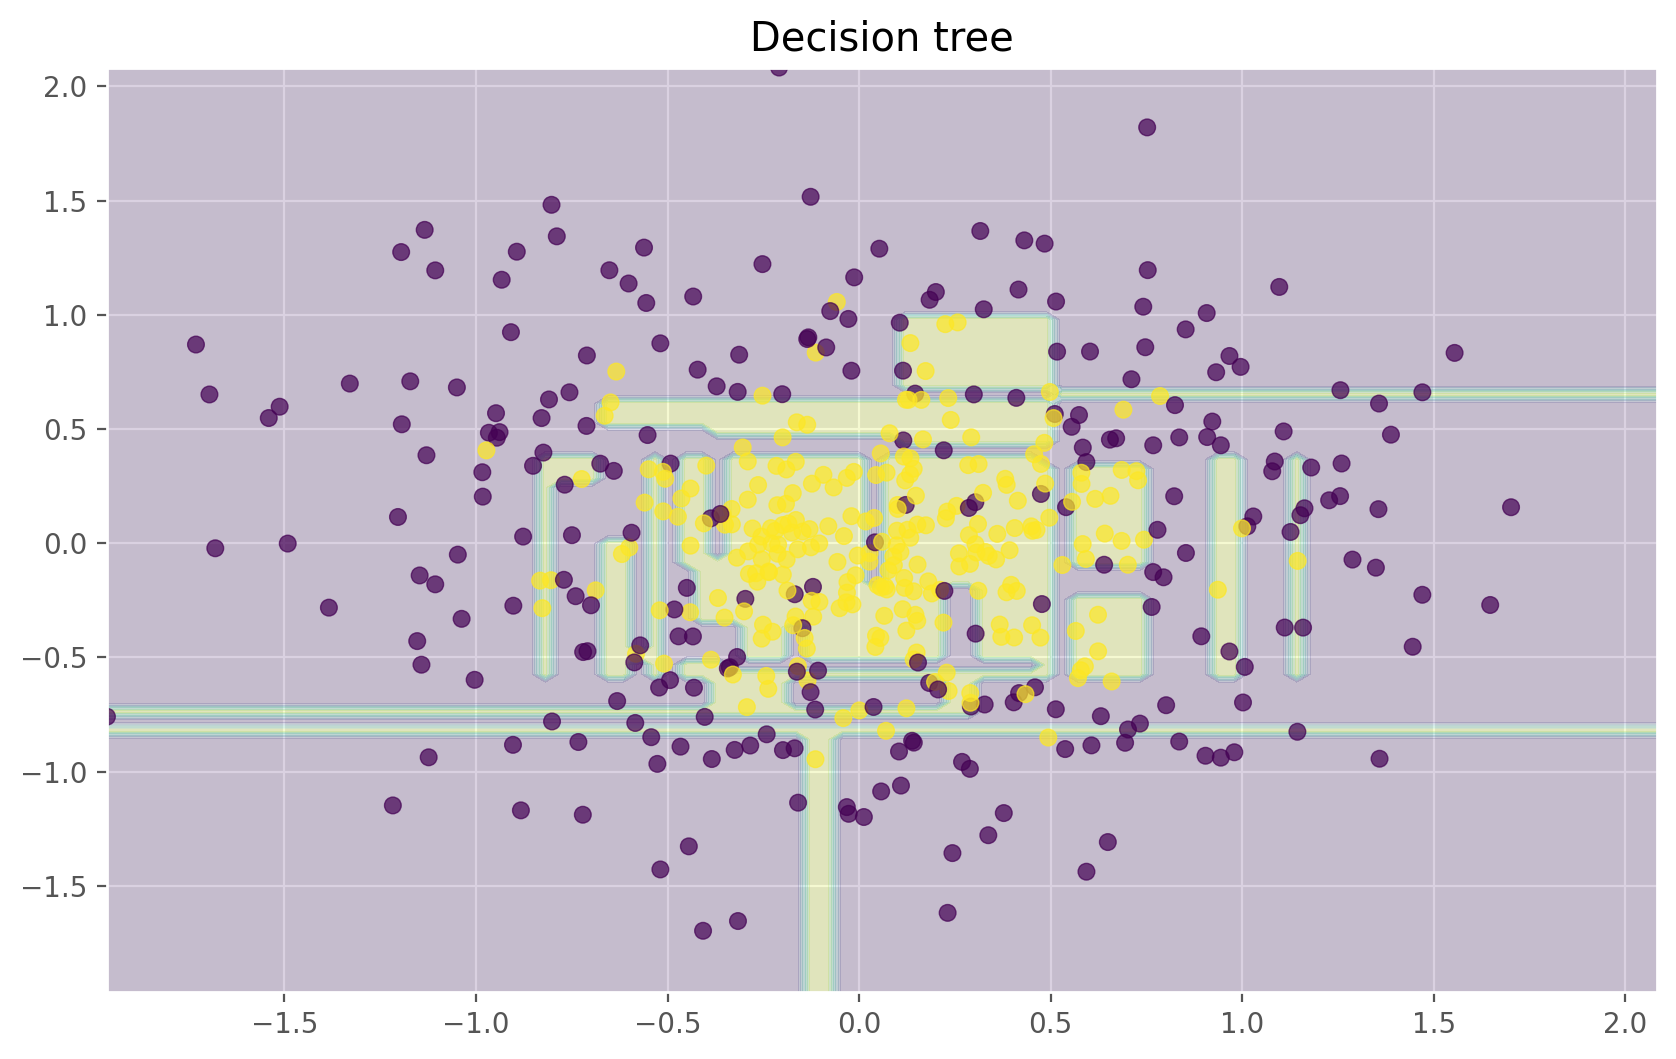

In [10]:
np.random.seed(42)
X, y = make_circles(n_samples=500, factor=0.1, noise=0.35, random_state=42)
X_train_circles, X_test_circles, y_train_circles, y_test_circles = \
    train_test_split(X, y, test_size=0.2)

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', alpha=.7)
plt.title("Decision tree")
plt.show()

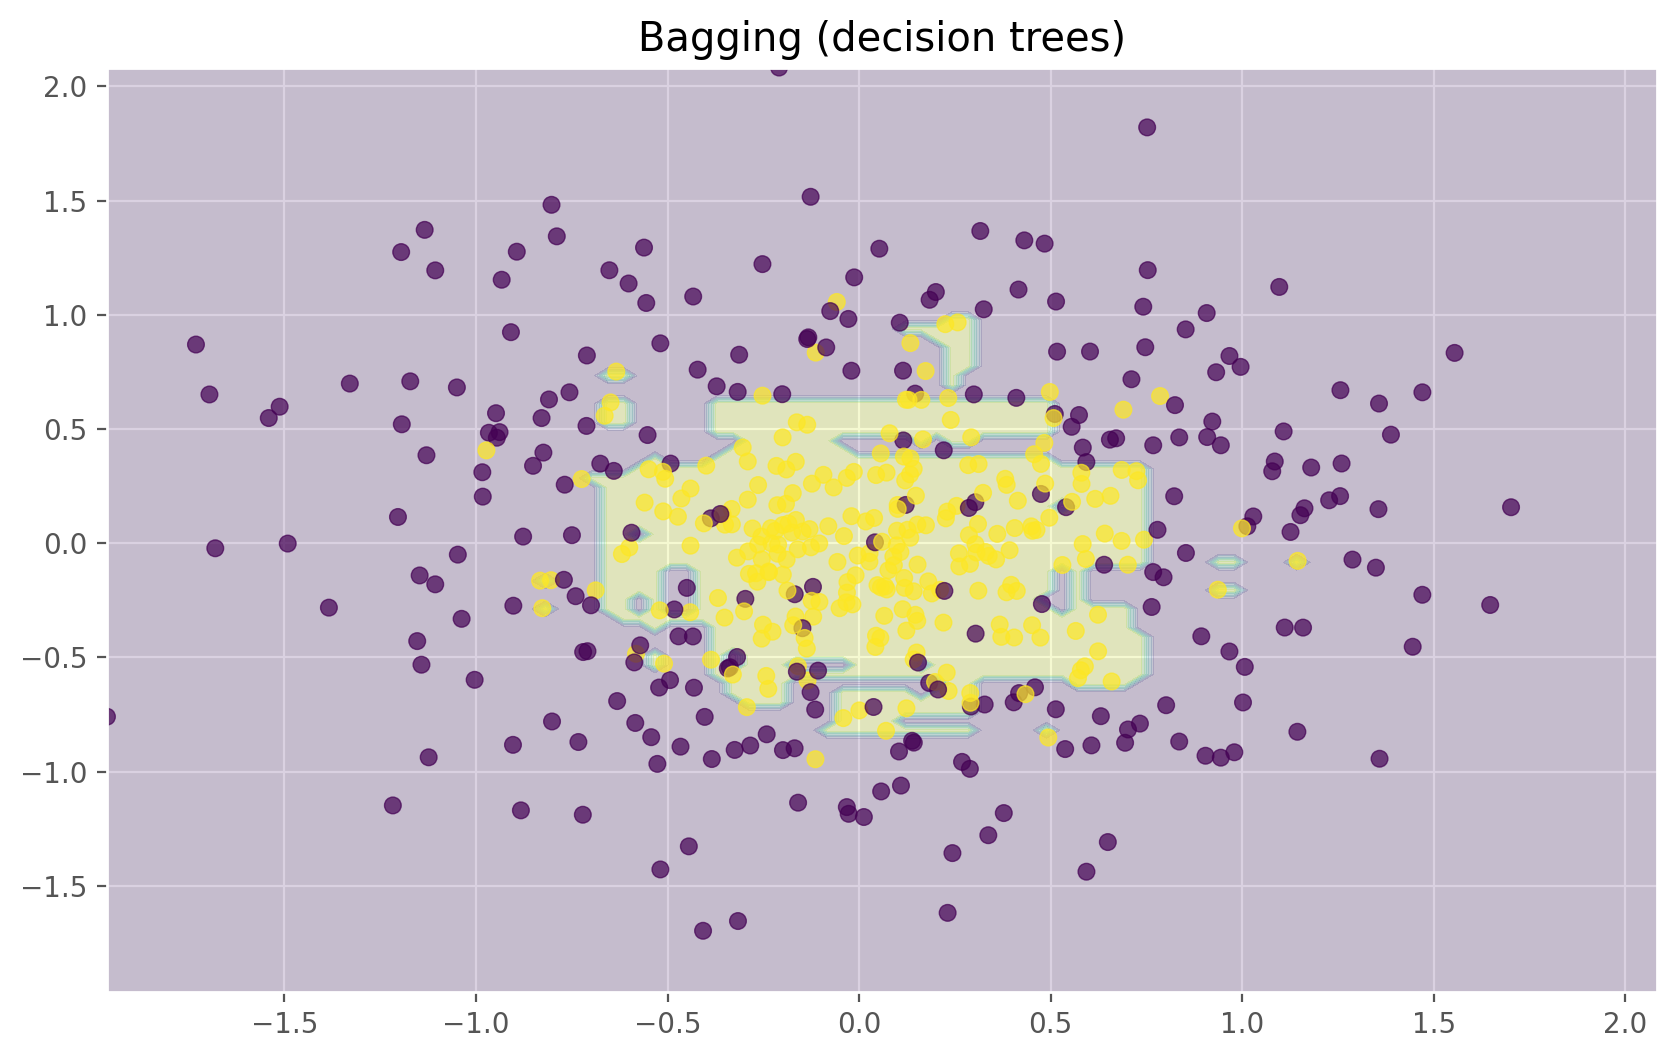

In [11]:
b_dtree = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=300, random_state=42)
b_dtree.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = b_dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', alpha=.7)
plt.title("Bagging (decision trees)")
plt.show()

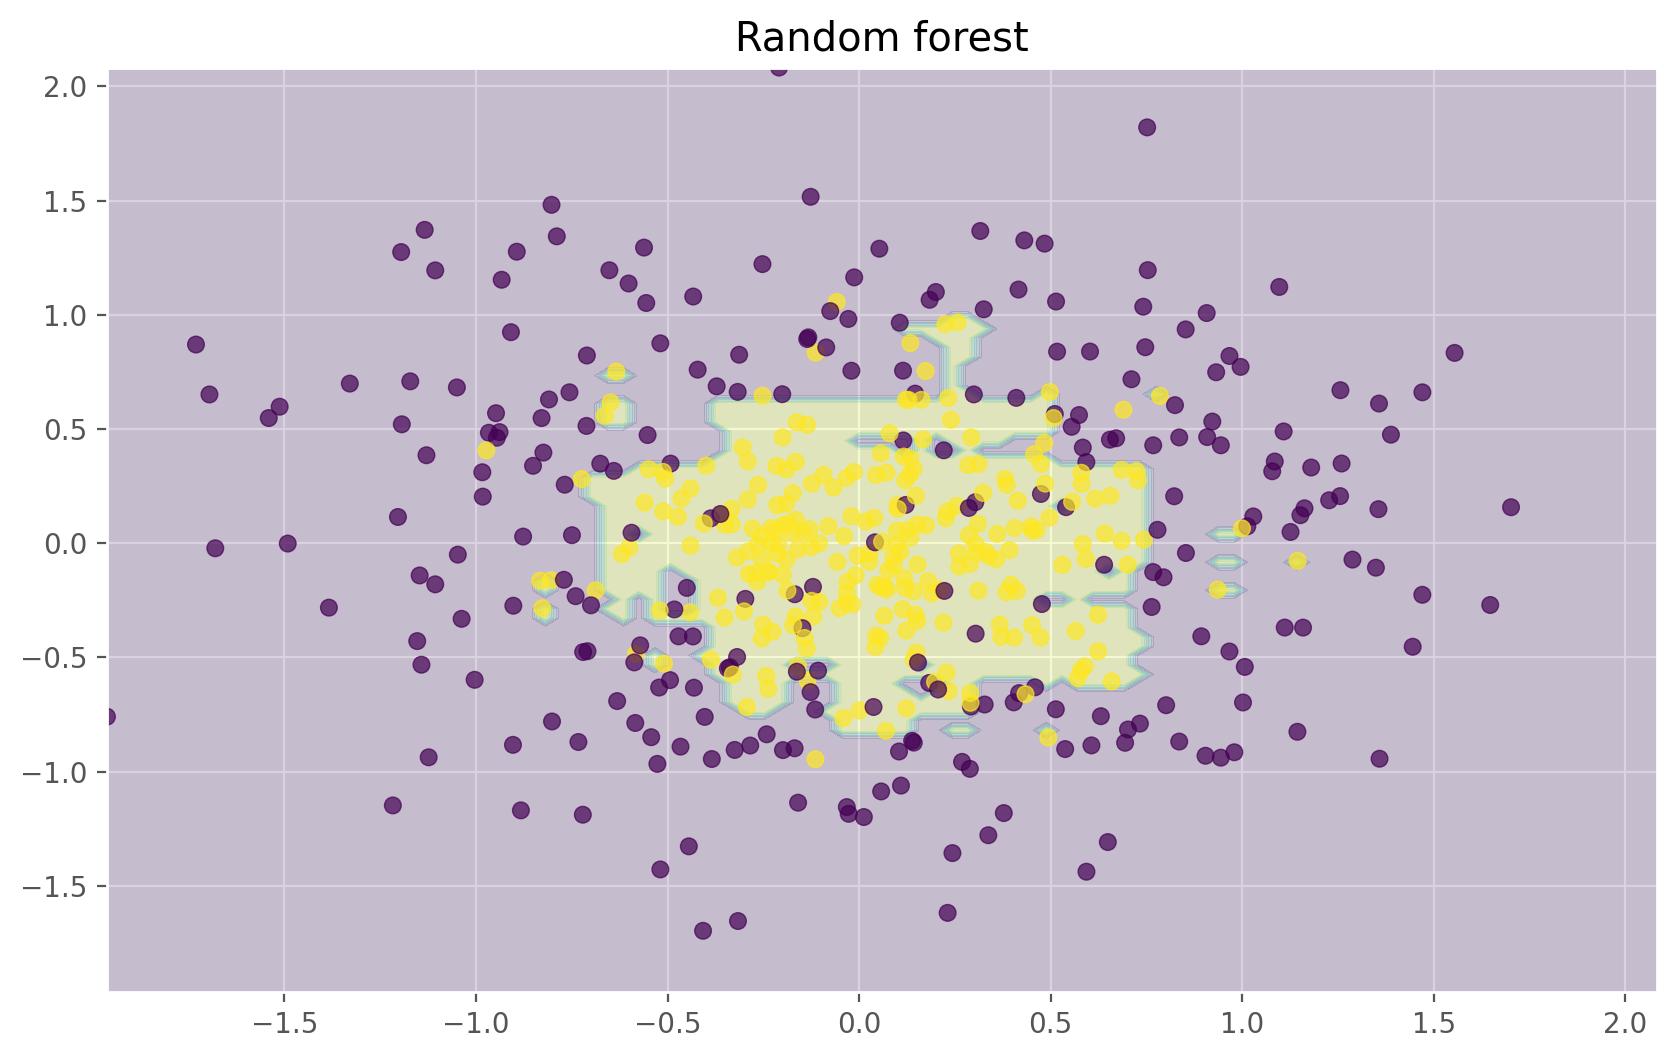

In [12]:
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', alpha=.7)
plt.title("Random forest")
plt.show()

The figures above show that the decision boundary of the decision tree is quite jagged and has a lot of acute angles that suggest overfitting and a weak ability to generalize. We would have trouble making reliable predictions on new test data. In contrast, the bagging algorithm has a rather smooth boundary and has no obvious signs of overfitting.

Now, let's investigate some parameters which can help us increase the model accuracy.

## Parameters

The [scikit-learn library](http://scikit-learn.org/stable/) implements random forests by providing two estimators: `RandomForestClassifier` and `RandomForestRegressor`.

The full list of random forest parameters for regression is shown below:


   - `n_estimators` — the number of trees in the forest (default = 10)
   - `criterion` — the function used to measure the quality of a split. Supported criteria are "mse" for the mean squared error, which is equal to variance reduction as feature selection criterion, and "mae" for the mean absolute error (default = "mse")
   - `max_features` — the number of features to consider when looking for the best split. You can specify the number or percentage of features, or choose from the available values: "auto" (all features), "sqrt", "log2". (default = "auto")
   -  `max_depth` — the maximum depth of the tree (default means that nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples)
   -  `min_samples_split` — the minimum number of samples required to split an internal node. Can be specified as the number or as a percentage of a total number of samples (default = 2)
   -  `min_samples_leaf` — the minimum number of samples required at a leaf node(default = 1)
   -  `min_weight_fraction_leaf` — the minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided (default = 0)
   - `max_leaf_nodes` — the maximum number of leaves (default = no restrictions)
   - `min_impurity_split` — threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf (default = 1е-7)
   - `bootstrap` — whether bootstrap samples are used when building trees(default = True)
   - `oob_score` — whether to use out-of-bag samples to estimate the R^2 on unseen data (default = False)
   - `n_jobs` — the number of jobs to run in parallel for both fit and predict. If -1, then the number of jobs is set to the number of cores (default = 1)
   - `random_state` — if int, random_state is the seed used by the random number generator; if RandomState instance, random_state is the random number generator; if None, the random number generator is the RandomState instance used by np.random (default = None)
   - `verbose` — controls the verbosity of the tree building process (default = 0)
   - `warm_start` — when set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest (default = False)

In case of classification, parameters are mostly the same. Only the following differ for `RandomForestClassifier` as compared to `RandomForestRegressor`:

   - `criterion` — the function used to measure the quality of a split. Supported criteria are "gini" for the Gini impurity and "entropy" for the information gain. Note: this parameter is tree-specific (default = "gini")
   - `class_weight` — the weight of each class (by default all weights equal to 1, but you can create a dictionary with weights or specify it as "balanced" - uses the values of classes to automatically adjust weights inversely proportional to class frequencies in the input data or as "balanced_subsample" - the same as "balanced" except that weights are computed based on the bootstrap sample for every tree grown)

Below are the parameters which we need to pay attention to when we are building a new model:

- `n_estimators` — the number of trees in the forest;
- `criterion` — the function used to measure the quality of a split;
- `max_features` — the number of features to consider when looking for the best split;
- `min_samples_leaf` — the minimum number of samples required to be at a leaf node;
- `max_depth` — the maximum depth of the tree.

### Practice with random forests in a real problem
 
In this example we will look at predicting customer churn. This is a classification problem, so we will use accuracy for model evaluation.

First, let's build a simple classifier which we will use as a baseline. For the sake of simplicity, we will use only numeric features.

In [13]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score)

# Load data
df = pd.read_csv("https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/telecom_churn.csv")

# Choose the numeric features
cols = []
for i in df.columns:
    if (df[i].dtype == "float64") or (df[i].dtype == 'int64'):
        cols.append(i)
        
# Divide the dataset into the input and target
X, y = df[cols].copy(), np.asarray(df["Churn"],dtype='int8')

# Initialize a stratified split of our dataset for the validation process
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the classifier with the default parameters 
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train it on the training set
results = cross_val_score(rfc, X, y, cv=skf)

# Evaluate the accuracy on the test set
print("CV accuracy score: {:.2f}%".format(results.mean() * 100))

CV accuracy score: 92.50%


We have accuracy close to 92%. Now, let's try to improve this result, and take a look at the behavior of the learning curves when we change the basic parameters.

Let's start with the number of trees:

In [14]:
# Initialize the validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create lists to save the values of accuracy on training and test sets
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best CV accuracy is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best CV accuracy is 92.50% with 100 trees


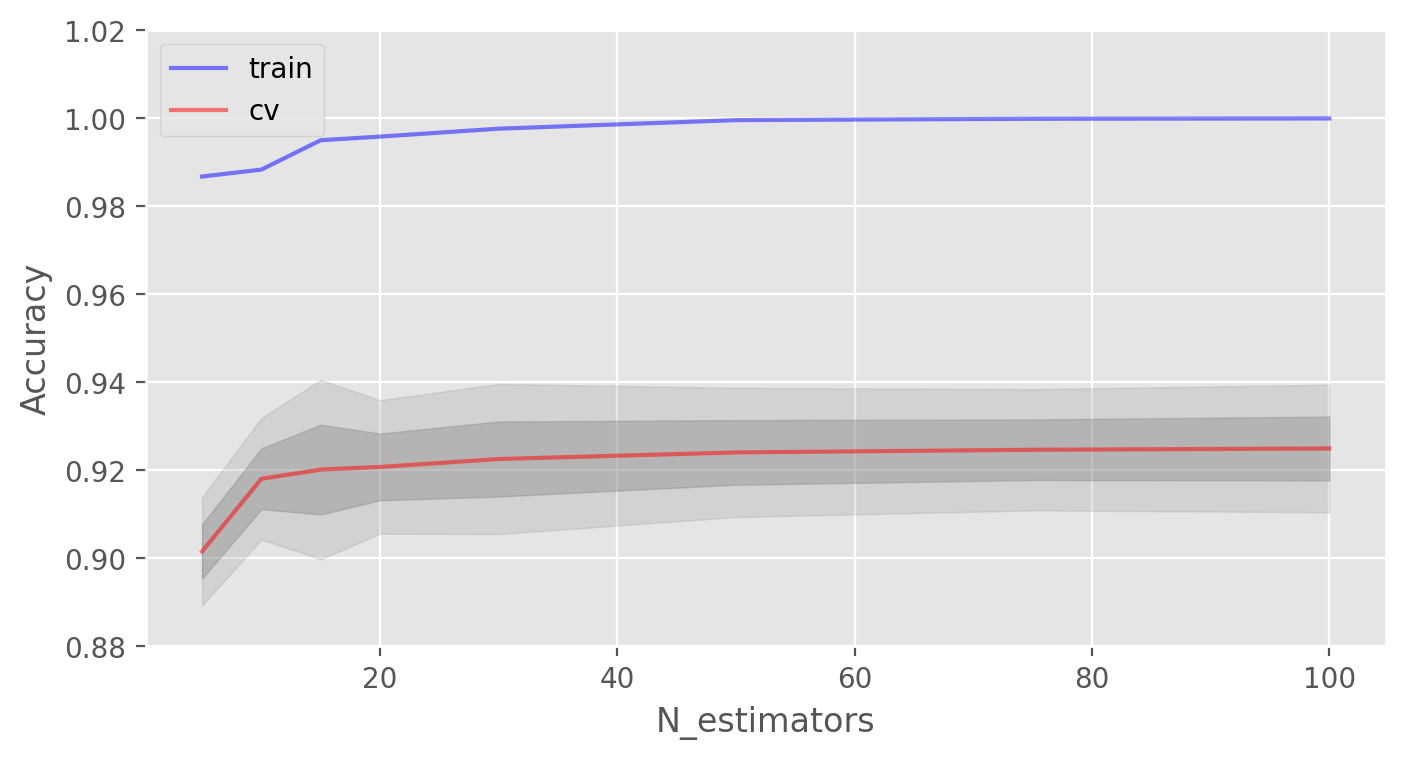

In [15]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), 
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), 
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators");

As you can see, when a certain number of trees is reached, our accuracy on the test set is very close to the asymptote. You can decide by yourself which value would be the optimal number of trees for your problem.

The figures also show that we achieved 100% accuracy on the training set, which tells us that we overfit. In order to avoid overfitting, we need to add regularization parameters to our model. 

We will start with the maximum depth of trees `max_depth` and fix the number of trees at 100:

Best CV accuracy is 92.44% with 24 max_depth


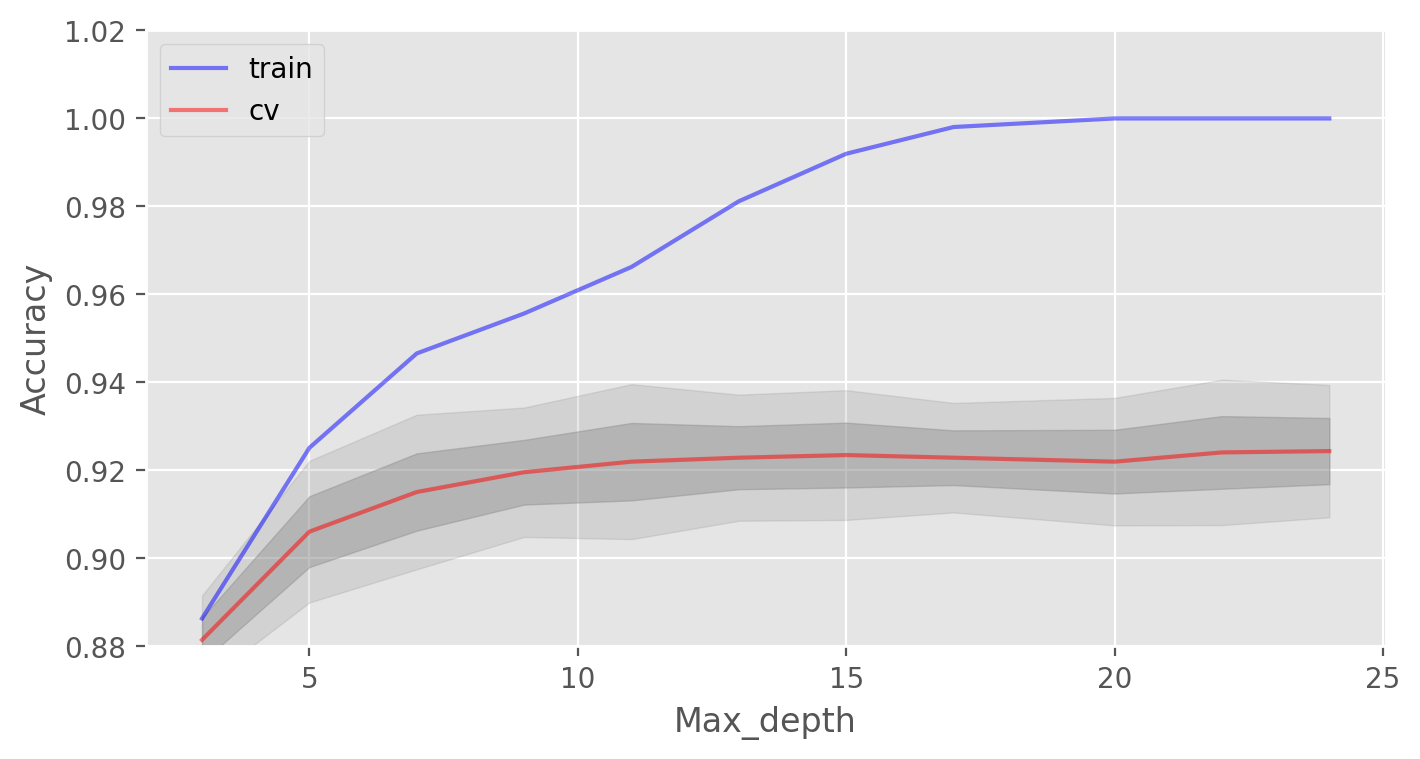

In [16]:
# Create lists to save accuracy values on the training and test sets
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best CV accuracy is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), 
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), 
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth");

Parameter `max_depth` copes well with the regularization of our model and it does not overfit as badly as before. The model accuracy has increased slightly.

Another important parameter worth tuning is `min_samples_leaf`. It also contributes to regularization.

In [17]:
# Create lists to save accuracy values on the training and test sets
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best CV accuracy is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Best CV accuracy is 92.50% with 1 min_samples_leaf


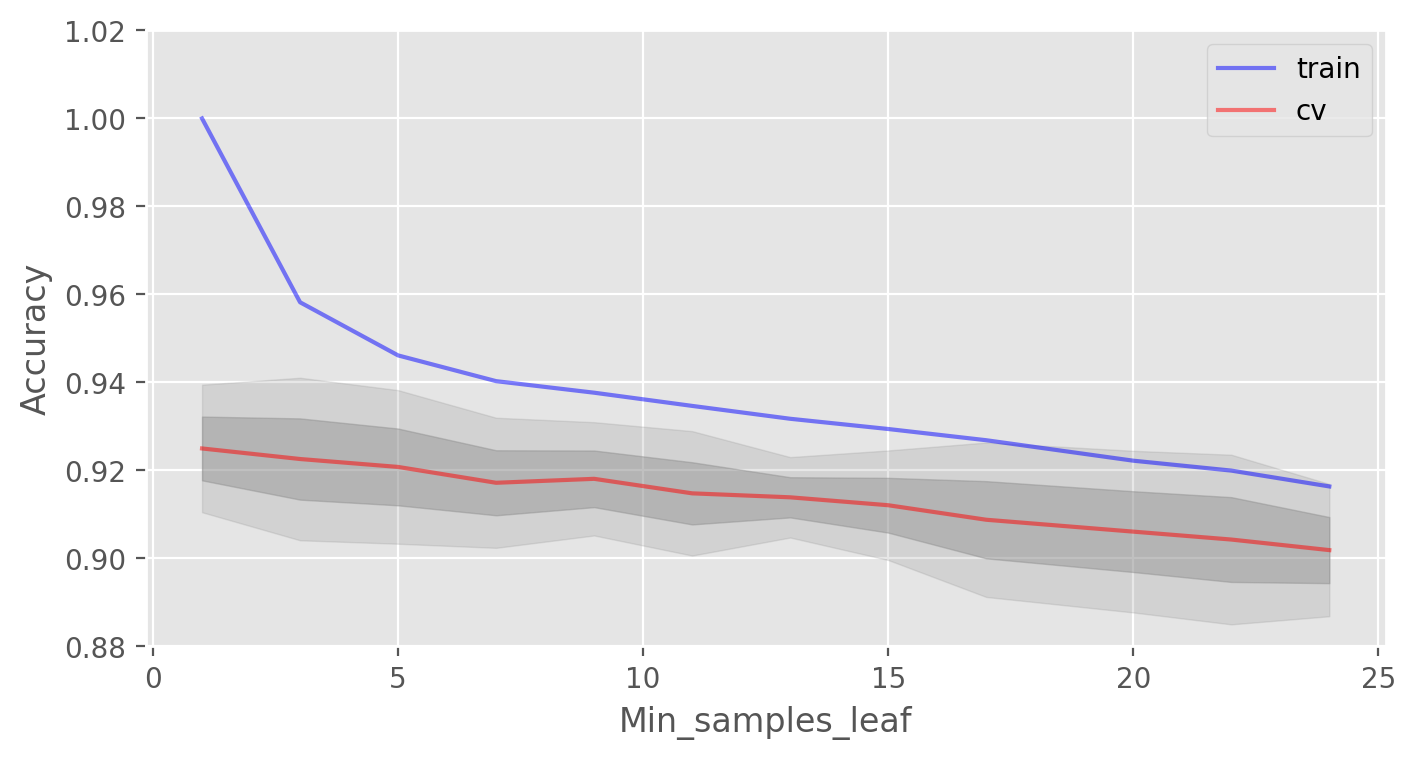

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), 
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), 
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf");

In this case, we do not see an improvement in accuracy on the validation set, but we significantly reduce the overfitting down to 2% while keeping the accuracy at about 92%.

Let's consider the parameter `max_features`. For classification, the value $\large \sqrt{d}$ (the total number of features) is typically used as the default choice. Let's check whether it would be optimal to use 4 features in our case:

Best CV accuracy is 92.50% with 4 max_features


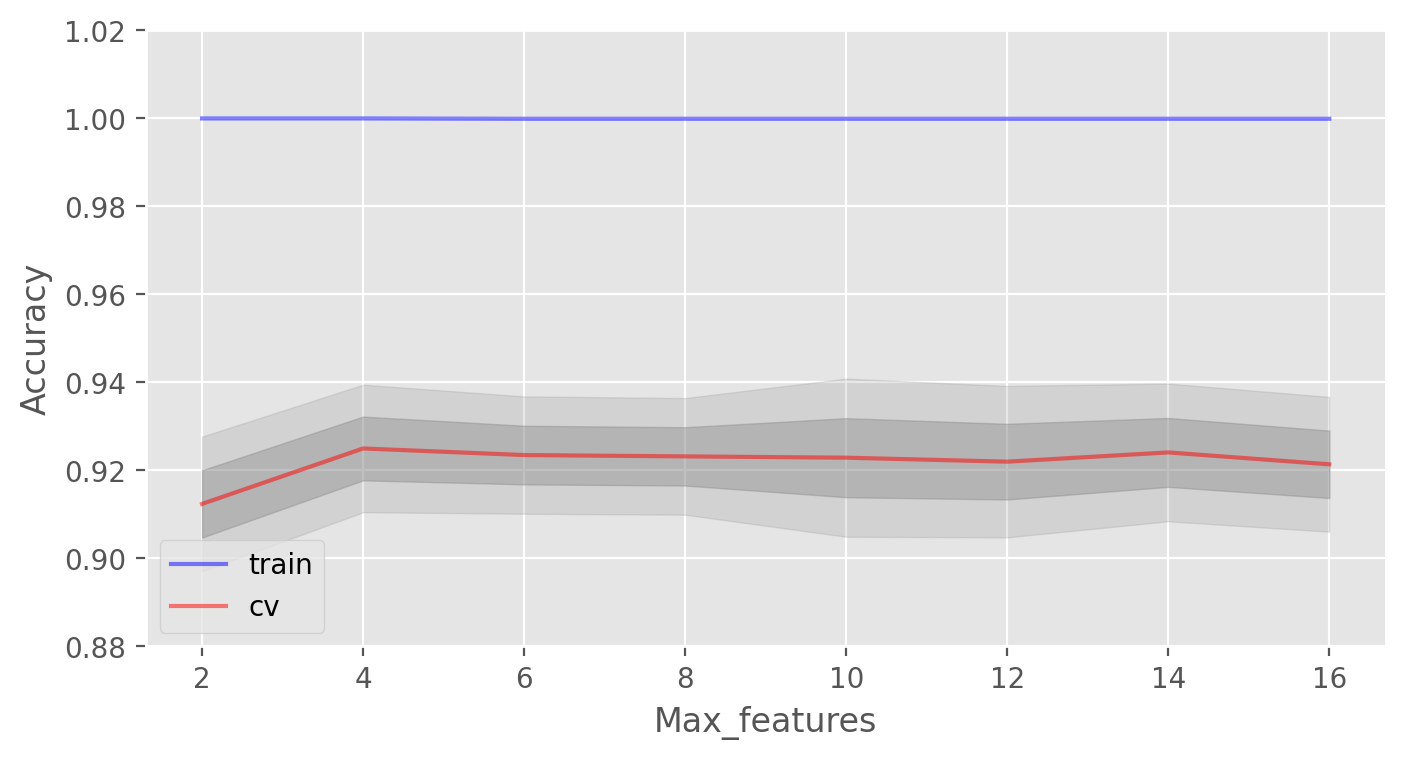

In [19]:
# Create lists to save accuracy values on the training and test sets
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best CV accuracy is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), 
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), 
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features");

In our case, the optimal number of features is equal to 10. This is the value at which the best result is achieved.

We have seen how the learning curves change with different values of the basic parameters. Now, let's use `GridSearch` to find the optimal parameters for our example:

In [20]:
# Initialize the set of parameters for exhaustive search and fit 
parameters = {'max_features': [4, 7, 10, 13], 
              'min_samples_leaf': [1, 3, 5, 7], 
              'max_depth': [5, 10, 15, 20]}
rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [4, 7, 10, 13],
                         'min_samples_leaf': [1, 3, 5, 7]},
             verbose=1)

In [21]:
gcv.best_params_, gcv.best_score_

({'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 3},
 0.925596661128895)

## Variance and Decorrelation

Let's write the variance of a random forest as

$$\large Var f(x) = \rho(x)\sigma^2(x)$$

$$\large \rho(x) = Corr\left[T(x_1,\Theta_1(Z)),T(x_2,\Theta_2(Z))\right],$$

where

* $\large \rho(x)$ is the sample correlation coefficient between any two trees used in averaging:
* $\large \Theta_1(Z)$ and $\large \Theta_2(Z)$ are a randomly selected pair of trees on randomly selected elements of the sample $Z$;
* $\large T(x,\Theta_i(Z))$ is the output of the $\large i$-th tree classifier on an input vector $\large x$;
* $\large \sigma^2(x)$ is the sample variance of any randomly selected tree:

$$\large \sigma^2(x) = Var\left[T(x,\Theta(X))\right]$$

It is easy to confuse $\large \rho(x)$ with the average correlation between the trained trees in a given random forest when we consider trees as N-vectors and calculate the average pairwise correlation between them. But this is not the case.

In fact, this conditional correlation is not directly related to the averaging process, and the dependence of $\large \rho(x)$ on $\large x$ warns us of this difference. $\large \rho(x)$ is the theoretical correlation between a pair of random trees estimated on the input $\large x$. Its value comes from the repeated sampling of the training set from the population $\large Z$ and the subsequent random choice of a pair of trees. In statistics jargon, this is the correlation caused by the sampling distribution of $\large Z$ and $\large \Theta$.

The conditional covariance of any pair of trees is equal to 0 because bootstrapping and feature selection are independent and identically distributed.

If we consider the variance of a single tree, it barely depends on the parameters of the splitting ($\large m$). But they are crucial for ensembles. The variance of a tree is much higher than the one of an ensemble. The book *The Elements of Statistical Learning (Trevor Hastie, Robert Tibshirani and Jerome Friedman)* has a great example that demonstrates this fact:

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/ml-advanced/ensemble-learning/random-forest/Comparison_of_Tree_and_Random_Forest.png
---
name: 'comparison of tree and random forest'
width: 90%
---
Comparison of Tree and Random Forest
:::

## Bias

Just as in bagging, the bias of a random forest is the same as the bias of a single tree $\large T(x,\Theta(Z))$:

$$ \large \begin{array}{rcl} Bias &=& \mu(x) - E_Z \, f_{rf}(x) \\
&=& \mu(x) - E_Z \, E_{\Theta | Z} \, T(x,\Theta(Z))\end{array}$$  

In absolute value, the bias is usually higher than that of an unprunned tree because randomization and sample space reduction impose their own restrictions on the model. Therefore, the improvements in prediction accuracy obtained by bagging and random forests are solely the result of variance reduction.

##  Extremely Randomized Trees

Extremely Randomized Trees employ a greater degree of randomization at the cut-point choice when splitting a tree node. As in random forests, a random subset of features is used. But, instead of the search for the optimal thresholds, their values are selected at random for each possible feature, and the best one among these randomly generated thresholds is used as the best rule to split the node. This usually trades off a slight reduction in the model variance with a small increase of the bias.

In the `scikit-learn` library, there are 2 implementations of Extremely Randomized Trees: [ExtraTreesClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier) and [ExtraTreesRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor). 

This method should be used if you have greatly overfit with random forests or gradient boosting.

## Similarities between Random Forest and k-Nearest Neighbors 
The random forest method is similar to the nearest neighbors technique. Random forests predictions are based on labels of alike examples from the training set. The more often these examples appear in the same leaf of a tree, the higher their similarity. Let's prove this formally.

Let's consider a regression problem with the quadratic loss function. Let $\large T_n(x)$ be the number of the leaf of the $\large n$-th tree in a random forest with input $\large x$.
The algorithm response for the input vector $\large x$ equals the averaged response over all the examples of the training sample that fall into the leaf $\large T_n(x)$. This can be written as

$$\large b_n(x) = \sum_{i=1}^{l}w_n(x,x_i)y_i,$$

where

$$ \large w_n(x, x_i) = \frac{\left[T_n(x) = T_n(x_i)\right]}{\sum_{j=1}^{l}\left[T_n(x) = T_n(x_j)\right]}$$  

Then, the response of the composition is

$$ \large \begin{array}{rcl} a_n(x) &=& \frac{1}{N}\sum_{n=1}^{N}\sum_{i=1}^{l}w_n(x,x_i)y_i \\
&=& \sum_{i=1}^{l}\left(\frac{1}{N}\sum_{j=1}^{N}w_n(x,x_j)\right)y_i \end{array}$$

You can see that the response of a random forest is a weighted sum of responses over all training examples.

It is also worth noting that the number of the leaf $ \large T_n(x)$, where the instance $\large x$ ended up, is a valuable feature by itself. For example, the following approach works well: 1) A composition of a small number of trees is trained on a sample using a random forest or gradient boosting. 2) The categorical features $\large T_1(x), \dots, T_n(x)$ are added to the sample.

These new features are the result of the non-linear space splitting, and they provide information about similarity between examples. In the book *The Elements of Statistical Learning*, there is a good illustrative example that demonstrates this similarity between random forests and the k-nearest neighbors technique:

:::{figure} https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/ml-advanced/ensemble-learning/random-forest/Comparison_of_Tree_and_Random_Forest.png
---
name: 'similarity between random forests and knn'
width: 90%
---
Similarity between random forests and knn
:::

## Transformation of a dataset into a high-dimensional representation

Random forests are mostly used in supervised learning, but there is a way to apply them in the unsupervised setting.

Using the `scikit-learn` method [RandomTreesEmbedding](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomTreesEmbedding.html#sklearn.ensemble.RandomTreesEmbedding), we can transform our dataset into a high-dimensional, [sparse](https://en.wikipedia.org/wiki/Sparse_matrix) representation. We first build extremely randomized trees and then use the index of the leaf containing the example as a new feature.

For example, if the input appears in the first leaf, we assign $1$ as the feature value; if not, we assign $0$. This is a so-called *binary coding*. We can control the number of features and the sparseness of data by increasing or decreasing the number of trees and their depth. Because nearby data points are likely to fall into the same leaf, this transformation provides an implicit nonparametric estimate of their density.

## Pros and cons of random forests

### Pros:

- High prediction accuracy; will perform better than linear algorithms in most problems; the accuracy is comparable with that of boosting.
- Robust to outliers, thanks to random sampling.
- Insensitive to the scaling of features as well as any other monotonic transformations due to the random subspace selection.
- Doesn't require fine-grained parameter tuning, works quite well out-of-the-box. With tuning, it is possible to achieve a 0.5-3% gain in accuracy, depending on the problem setting and data.
- Efficient for datasets with a large number of features and classes.
- Handles both continuous and discrete variables equally well.
- Rarely overfits. In practice, an increase in the tree number almost always improves the composition. But, after reaching a certain number of trees, the learning curve is very close to the asymptote.
- There are developed methods to estimate feature importance.
- Works well with missing data and maintains good accuracy even when a large part of data is missing.
- Provides means to weight classes on the whole dataset as well as for each tree sample.
- Under the hood, calculates proximities between pairs of examples that can subsequently be used in clustering, outlier detection, or interesting data representations.
- The above functionality and properties may be extended to unlabeled data to enable unsupervised clustering, data visualization, and outlier detection.
- Easily parallelized and highly scalable.

### Cons:

 - In comparison with a single decision tree, Random Forest's output is more difficult to interpret.
 - There are no formal p-values for feature significance estimation.
 - Performs worse than linear methods in the case of sparse data: text inputs, bag of words, etc.
 - Unlike linear regression, Random Forest is unable to extrapolate. But, this can be also regarded as an advantage because outliers do not cause extreme values in Random Forests.
 - Prone to overfitting in some problems, especially, when dealing with noisy data.
 - In the case of categorical variables with varying level numbers, random forests favor variables with a greater number of levels. The tree will fit more towards a feature with many levels because this gains greater accuracy.
 - If a dataset contains groups of correlated features, preference might be given to groups of smaller size. See [this work](http://rnowling.github.io/machine/learning/2015/08/11/random-forest-correlation-bias.html).
 - The resulting model is large and requires a lot of RAM.

## Your turn! 🚀

TBD

## Acknowledgments

Thanks to [Yury Kashnitsky](https://www.kaggle.com/kashnitsky) for creating the open-source content [Ensembles and random forest](https://www.kaggle.com/code/kashnitsky/topic-5-ensembles-part-2-random-forest/notebook). They inspire the majority of the content in this chapter.